# CS-483: Big Data Mining - Progress Report
# Interpreting Algorithmic Fairness via Aleatoric and Epistemic Uncertainties
##### By Zohair Hashmi | Sajal Chandra | Rayaan Siddiqi | Sean Kudrna

### Part 2 : Aleatoric Uncertainty & Fairness Estimation

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.datasets import StructuredDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german

from IPython.display import Markdown, display

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping


import keras_uncertainty as ku
import keras_uncertainty.backend as K

from keras_uncertainty.layers import StochasticDropout
from keras_uncertainty.layers import DropConnectDense, VariationalDense, FlipoutDense, SamplingSoftmax
from keras_uncertainty.utils import numpy_entropy


`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_d

Keras Uncertainty will use standalone Keras backend

### LOADING DATASET FROM AIF360

Currently we are working with "Adult Dataset" in this notebook. The following code loads the dataset from AIF360. The dataset is already split into train and test sets. We will use the train set to train our models and the test set to evaluate the models.

In [2]:
# load dataset
dataset_orig = load_preproc_data_adult()

# split into train and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.80], shuffle=True)

# priveleged and unpriveleged groups
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print(dataset_orig_test.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Priveleged and unpriveleged groups"))
print(privileged_groups, unprivileged_groups)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(39073, 18)


#### Test Dataset shape

(9769, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Priveleged and unpriveleged groups

[{'sex': 1}] [{'sex': 0}]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [3]:
#tabulate training dataset  
display(Markdown("#### Training Dataset"))
train_df = dataset_orig_train.convert_to_dataframe()[0].reset_index(drop=True)
train_df

#### Training Dataset

,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,Age (decade)=>=70,Education Years=6,Education Years=7,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,Income Binary
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39068,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39069,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39070,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39071,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [4]:
# create a function for the above steps
def add_noise_to_dataset(num_samples):
    # 10,000 random zero-one entries
    random_race = np.random.randint(2, size=num_samples)
    random_sex = np.random.randint(2, size=num_samples)

    # Expand the dimensions of array1 to make it compatible for concatenation
    random_race = np.expand_dims(random_race, axis=1)
    random_sex = np.expand_dims(random_sex, axis=1)

    # 10,000 x 7 random zero-one entries, with only one 1 in each row
    random_age_onehot = np.zeros((num_samples, 7))
    random_age_onehot[np.arange(num_samples), np.random.randint(7, size=num_samples)] = 1

    # 10,000 x 9 random zero-one entries, with only one 1 in each row
    random_education_onehot = np.zeros((num_samples, 9))
    random_education_onehot[np.arange(num_samples), np.random.randint(9, size=num_samples)] = 1

    # 10,000 random zero-one entries
    random_income = np.random.randint(2, size=num_samples)
    # Expand the dimensions of array1 to make it compatible for concatenation
    random_income = np.expand_dims(random_income, axis=1)

    randomized_samples = np.concatenate((random_race, random_sex, random_age_onehot, random_education_onehot, random_income), axis=1)

    return randomized_samples

In [5]:
noise_frac = np.linspace(0.1, 1.0, 10)

train_df.shape, add_noise_to_dataset(int(len(train_df)*noise_frac[0])).shape
temp = pd.DataFrame(add_noise_to_dataset(int(len(train_df)*noise_frac[0])))

pd.concat([temp,train_df.loc[:]]).reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,...,Education Years=6,Education Years=7,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,Income Binary
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
42976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
42978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [8]:
# concatenate temp_df to train_df and create 10 different train sets wi
train_sets = {}
noise_frac = np.linspace(0.1, 0.5, 9)
for i in range(len(noise_frac)):
    temp = add_noise_to_dataset(int(len(train_df)*noise_frac[i]))
    # print(temp.shape)
    temp_df = pd.DataFrame(temp)
    temp_df.columns = train_df.columns
    samp = train_df.sample(frac=noise_frac[i])
    # print(samp.shape)
    train_reduced = train_df.loc[~train_df.index.isin(samp.index)]
    # print(train_reduced.shape, samp.shape)
    train_sets[i] = pd.concat([train_reduced, temp_df], axis=0)
    del temp

In [9]:
#print the shape of each train group for different noise levels
for i in range(len(noise_frac)):
    print('train set of additional', np.round(noise_frac[i],2) * 100, '% noise has shape', train_sets[i].shape)

train set of additional 10.0 % noise has shape (39073, 19)
train set of additional 15.0 % noise has shape (39072, 19)
train set of additional 20.0 % noise has shape (39072, 19)
train set of additional 25.0 % noise has shape (39073, 19)
train set of additional 30.0 % noise has shape (39072, 19)
train set of additional 35.0 % noise has shape (39072, 19)
train set of additional 40.0 % noise has shape (39073, 19)
train set of additional 45.0 % noise has shape (39072, 19)
train set of additional 50.0 % noise has shape (39073, 19)


The above files are now stored as .pkl files in the directory. Use these files directly for running model tests.

In [10]:
# save train_sets to file
import pickle
with open('adult_results_aleatoric/train_sets.pickle', 'wb') as handle:
    pickle.dump(train_sets, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save test set to file
with open('adult_results_aleatoric/test_set.pickle', 'wb') as handle:
    pickle.dump(dataset_orig_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

### Loading the dataset from the .pkl files

In [11]:
# load train sets from file
import pickle
with open('adult_results_aleatoric/train_sets.pickle', 'rb') as handle:
    train_sets = pickle.load(handle)

# load test set from file
with open('adult_results_aleatoric/test_set.pickle', 'rb') as handle:
    dataset_orig_test = pickle.load(handle)

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
    

### MODEL DEFINITIONS

In [12]:
class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=1, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=batch_size, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)

class StochasticClassifier(StochasticModel):
    def __init__(self, model, num_samples=10):
        super().__init__(model, num_samples)

    def predict(self, inp, num_samples=None, batch_size=32, **kwargs):
        """
            Performs a prediction given input inp using MC Dropout, and returns the averaged probabilities of model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        mean_probs = np.mean(samples, axis=0)
        mean_probs = mean_probs / np.sum(mean_probs, axis=1, keepdims=True)

        return mean_probs

class  StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10):
        super().__init__(model, num_samples)

    def predict(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)

        return mean_pred, std_pred    

class TwoHeadStochasticRegressor(StochasticModel):
    """
        A stochastic model that has two ouput heads, one for mean and another for variance, useful for aleatoric/epistemic uncertainty estimation.
    """
    def __init__(self, model, num_samples=10, variance_type="linear_variance"):
        super().__init__(model, num_samples)

        assert variance_type in ["logit", "linear_std", "linear_variance"]
        self.variance_type = variance_type

    """
        Preprocesses and interprets the variance output prodcued by the model, producing a standard deviation.
    """
    def preprocess_variance_output(self, var_input):
        if self.variance_type is "logit":
            return np.exp(var_input)

        if self.variance_type is "linear_variance":
            return np.sqrt(var_input)
        
        return var_input

    def predict(self, inp, num_samples=None, batch_size=32, output_scaler=None, disentangle_uncertainty=False, **kwargs):
        """
            Performs a prediction given input inp and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, multi_output=True, **kwargs)
        mean_samples, var_samples = [x[0] for x in samples], [x[1] for x in samples]

        if output_scaler is not None:
            mean_samples = list(map(lambda x: output_scaler.inverse_transform(x), mean_samples))
            var_samples = list(map(lambda x: output_scaler.inverse_transform(x), var_samples))

        means = np.array(mean_samples)
        variances = np.array(var_samples)
        stds = self.preprocess_variance_output(variances)
        
        mixture_mean = np.mean(means, axis=0)
        mixture_var  = np.mean(np.square(stds) + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
        mixture_std = np.sqrt(mixture_var)
                                
        if disentangle_uncertainty:            
            epi_std = np.std(means, axis=0)
            ale_std = np.mean(stds, axis=0)

            return mixture_mean, ale_std, epi_std

        return mixture_mean, mixture_std

class KernelDensityStochasticModel(StochasticModel):
    def __init__(self, model, num_samples=10, bandwidth=1.0):
        super().__init__(model, num_samples)

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)

    return np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims=True)

def sampling_softmax(mean_logit, std_logit, num_samples=10):
    logit_shape = (mean_logit.shape[0], num_samples, mean_logit.shape[-1])

    logit_mean = np.expand_dims(mean_logit, axis=1)
    logit_mean = np.repeat(logit_mean, num_samples, axis=1)

    logit_std = np.expand_dims(std_logit, axis=1)
    logit_std = np.repeat(logit_std, num_samples, axis=1)

    logit_samples = np.random.normal(size=logit_shape, loc=logit_mean, scale=logit_std)

    prob_samples = softmax(logit_samples, axis=-1)
    probs = np.mean(prob_samples, axis=1)

    # This is required due to approximation error, without it probabilities can sum to 1.01 or 0.99
    probs = probs / np.sum(probs, axis=-1, keepdims=True) 

    return probs

class DisentangledStochasticClassifier(TwoHeadStochasticRegressor):
    def __init__(self, model, epi_num_samples=10, ale_num_samples=100) -> None:
        super(DisentangledStochasticClassifier, self).__init__(model, num_samples=epi_num_samples)

        self.epi_num_samples = epi_num_samples
        self.ale_num_samples = ale_num_samples

    def predict(self, inp, num_samples=None, batch_size=32):
        y_logits_mean, y_logits_std_ale, y_logits_std_epi = TwoHeadStochasticRegressor.predict(self, inp, num_samples=num_samples, batch_size=batch_size, disentangle_uncertainty=True)

        y_probs = sampling_softmax(y_logits_mean, y_logits_std_ale + y_logits_std_epi, num_samples=self.ale_num_samples)
        y_probs_epi = sampling_softmax(y_logits_mean, y_logits_std_epi, num_samples=self.ale_num_samples)
        y_probs_ale = sampling_softmax(y_logits_mean, y_logits_std_ale, num_samples=self.ale_num_samples)

        return y_probs, y_probs_ale, y_probs_epi



<>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Zohair Hashmi\AppData\Local\Temp\ipykernel_26832\1140481961.py:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.variance_type is "logit":
C:\Users\Zohair Hashmi\AppData\Local\Temp\ipykernel_26832\1140481961.py:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.variance_type is "linear_variance":


In [24]:
def uncertainty(probs):
    return numpy_entropy(probs, axis=-1)

def two_head_model(trunk_model, num_classes=2, num_samples=100):
    inp = Input(shape=(18,))
    x = trunk_model(inp)
    logit_mean = Dense(num_classes, activation="linear")(x)
    logit_var = Dense(num_classes, activation="softplus")(x)
    probs = SamplingSoftmax(num_samples=num_samples, variance_type="linear_std")([logit_mean, logit_var])
    
    train_model = Model(inp, probs, name="train_model")
    pred_model = Model(inp, [logit_mean, logit_var], name="pred_model")

    train_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return train_model, pred_model

def train_eval_stochastic_model(trunk_model, x_train, y_train, domain, epochs=300):
    train_model, pred_model = two_head_model(trunk_model)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
    train_model.fit(x_train, y_train, verbose=2, epochs=epochs, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[es])
    
    fin_model = DisentangledStochasticClassifier(pred_model, epi_num_samples=NUM_SAMPLES)
    print("predicting...")
    pred_mean, pred_ale_std, pred_epi_std = fin_model.predict(domain, batch_size=BATCH_SIZE)
    print("prediction completed")
    ale_entropy = uncertainty(pred_ale_std)
    epi_entropy = uncertainty(pred_epi_std)

    return pred_mean, ale_entropy, epi_entropy

def train_dropout_model(x_train, y_train, domain, prob=0.5):
    model = Sequential()
    model.add(Dense(32, activation="relu", input_shape=(x_train.shape[1],)))
    model.add(StochasticDropout(prob))
    model.add(Dense(32, activation="relu"))
    model.add(StochasticDropout(prob))

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return train_eval_stochastic_model(model, x_train, y_train, domain, epochs=100)

def train_ensemble_model(x_train, y_train, domain, ensemble_size=10):
    models = []
    for i in range(ensemble_size):
        model = Sequential()
        model.add(Dense(32, activation="relu", input_shape=(x_train.shape[1],)))
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.1)))
        model.add(Dense(2, activation="linear"))

        model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      metrics=[tf.keras.metrics.BinaryAccuracy(),
                               tf.keras.metrics.FalseNegatives()])

        models.append(model)

    ale_entropy = 0
    epi_entropy = 0
    pred = []
    i = 0

    for model in models:
        pred_prob, ale, epi = train_eval_stochastic_model(model, x_train, y_train, domain, epochs=100)
        ale_entropy += ale
        epi_entropy += epi
        pred.append(pred_prob)
        print('ensemble model ', i + 1, ' trained')
        i += 1

    ale_entropy /= ensemble_size
    epi_entropy /= ensemble_size
    # average the prediction
    pred = np.array(pred)
    pred = np.mean(pred, axis=0)
    return pred, ale_entropy, epi_entropy

def train_dropout_ensemble_model(x_train, y_train, domain, prob=0.5, ensemble_size=10):
    models = []
    for i in range(ensemble_size):
        model = Sequential()
        model.add(Dense(32, activation="relu", input_shape=(x_train.shape[1],)))
        model.add(StochasticDropout(prob))
        model.add(Dense(32, activation="relu"))
        model.add(StochasticDropout(prob))

        model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        models.append(model)

    ale_entropy = 0
    epi_entropy = 0
    pred = []
    i = 0

    for model in models:
        pred_prob, ale, epi = train_eval_stochastic_model(model, x_train, y_train, domain, epochs=100)
        ale_entropy += ale
        epi_entropy += epi
        pred.append(pred_prob)
        print('ensemble model ', i + 1, ' trained')
        i += 1

    ale_entropy /= ensemble_size
    epi_entropy /= ensemble_size
    pred = np.array(pred)
    pred = np.mean(pred, axis=0)

    return pred, ale_entropy, epi_entropy
        
NUM_SAMPLES = 50
BATCH_SIZE = 256

### FAIRNESS METRICS - EQUALITY OF OPPORTUNITY

In [14]:
# function to assign prediction based on threshold
def assign_pred(pred_prob, class_threshold):
    predicted_labels = []
    for i in range(len(pred_prob)):
        predictions = []
        for x in pred_prob[i][:,0]:
            if x > class_threshold:
                predictions.append(0.0)
            else:
                predictions.append(1.0)
        predicted_labels.append(predictions)

    return predicted_labels

#function for equal opportunity difference for each threshold
def equal_opportunity_difference(dataset_orig_test, pred_prob, class_threshold):
    predicted_labels = assign_pred(pred_prob, class_threshold)
    df_test = dataset_orig_test.convert_to_dataframe()[0]
    equal_opportunity_difference = []
    for i in range(0, len(predicted_labels)):
        df_test['Income Binary'] = predicted_labels[i]

        structured_dataset = StructuredDataset(df_test, dataset_orig_test.label_names, dataset_orig_test.protected_attribute_names)

        structured_binary_dataset = BinaryLabelDataset(df=structured_dataset.convert_to_dataframe()[0], 
                                         label_names=dataset_orig_test.label_names, 
                                         protected_attribute_names=dataset_orig_test.protected_attribute_names, 
                                         favorable_label=dataset_orig_test.favorable_label, 
                                         unfavorable_label=dataset_orig_test.unfavorable_label)
        
        classified_metric = ClassificationMetric(dataset_orig_test, 
                                                 structured_binary_dataset,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
        
        equal_opportunity_difference.append(abs(classified_metric.equal_opportunity_difference()))
        print("Equal opportunity difference for dataset of size %.2f = %f" % (i*0.1+0.1, abs(classified_metric.equal_opportunity_difference())))
            #    = %f" % abs(classified_metric.equal_opportunity_difference()))

    return equal_opportunity_difference

In [15]:
import tensorflow as tf
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### ENSEMBLE MODEL

In [25]:
# train ensemble model for dataset size 0.1 to 1.0
ale_entropy_ensemble = []
epi_entropy_ensemble = []
pred_prob_ensemble = []

for i in range(len(noise_frac)):
    print('Noise level (%): ', noise_frac[i]*100)
    pred, ale_entropy, epi_entropy = train_ensemble_model(train_sets[0].drop(['Income Binary'], axis=1), train_sets[0]['Income Binary'], dataset_orig_test.features, ensemble_size=10)
    print('ale entropy: ', np.mean(ale_entropy))
    print('epi entropy: ', np.mean(epi_entropy))

    # save ale and epi entropy
    ale_entropy_ensemble.append(ale_entropy)
    epi_entropy_ensemble.append(epi_entropy)
    pred_prob_ensemble.append(pred)

    print('')

Noise level (%):  10.0
Epoch 1/100
123/123 - 2s - loss: 2.4076 - accuracy: 0.7452 - val_loss: 1.5930 - val_accuracy: 0.6237 - 2s/epoch - 16ms/step
Epoch 2/100
123/123 - 1s - loss: 0.9158 - accuracy: 0.7928 - val_loss: 1.0058 - val_accuracy: 0.6461 - 888ms/epoch - 7ms/step
Epoch 3/100
123/123 - 1s - loss: 0.5295 - accuracy: 0.8048 - val_loss: 0.8470 - val_accuracy: 0.6418 - 814ms/epoch - 7ms/step
Epoch 4/100
123/123 - 1s - loss: 0.4470 - accuracy: 0.8040 - val_loss: 0.8546 - val_accuracy: 0.6441 - 801ms/epoch - 7ms/step
Epoch 5/100
123/123 - 1s - loss: 0.4313 - accuracy: 0.8052 - val_loss: 0.9079 - val_accuracy: 0.6457 - 820ms/epoch - 7ms/step
Epoch 6/100
123/123 - 1s - loss: 0.4275 - accuracy: 0.8042 - val_loss: 0.9258 - val_accuracy: 0.6426 - 807ms/epoch - 7ms/step
Epoch 7/100
123/123 - 1s - loss: 0.4270 - accuracy: 0.8048 - val_loss: 0.9216 - val_accuracy: 0.6456 - 816ms/epoch - 7ms/step
Epoch 8/100
123/123 - 1s - loss: 0.4265 - accuracy: 0.8046 - val_loss: 0.9079 - val_accuracy: 0.6

In [26]:
Equal_opp_diffs_ensemble = equal_opportunity_difference(dataset_orig_test, pred_prob_ensemble, 0.5)

Equal opportunity difference for dataset of size 0.10 = 0.469223
Equal opportunity difference for dataset of size 0.20 = 0.503532
Equal opportunity difference for dataset of size 0.30 = 0.470232
Equal opportunity difference for dataset of size 0.40 = 0.477800
Equal opportunity difference for dataset of size 0.50 = 0.465187
Equal opportunity difference for dataset of size 0.60 = 0.453078
Equal opportunity difference for dataset of size 0.70 = 0.468718
Equal opportunity difference for dataset of size 0.80 = 0.463169
Equal opportunity difference for dataset of size 0.90 = 0.452573


In [28]:
#mean of each entropy for each noise level
for i in range(len(noise_frac)):
    print('Noise level (%): ', noise_frac[i]*100)
    print('ale entropy: ', np.mean(ale_entropy_ensemble[i]))
    print('epi entropy: ', np.mean(epi_entropy_ensemble[i]))
    print('')


Noise level (%):  10.0
ale entropy:  0.43790135110236983
epi entropy:  0.4171562729410941

Noise level (%):  15.000000000000002
ale entropy:  0.4427134206842589
epi entropy:  0.420259060826066

Noise level (%):  20.0
ale entropy:  0.4390989696852026
epi entropy:  0.41589090246639915

Noise level (%):  25.0
ale entropy:  0.44493591685089817
epi entropy:  0.4220716292055145

Noise level (%):  30.000000000000004
ale entropy:  0.4388312614779528
epi entropy:  0.41782016570339175

Noise level (%):  35.0
ale entropy:  0.4353793758861871
epi entropy:  0.4154019512508738

Noise level (%):  40.0
ale entropy:  0.4419246639018731
epi entropy:  0.4168319282504738

Noise level (%):  45.00000000000001
ale entropy:  0.4416907993611144
epi entropy:  0.42014479267952715

Noise level (%):  50.0
ale entropy:  0.42606974953791465
epi entropy:  0.40334128336765396



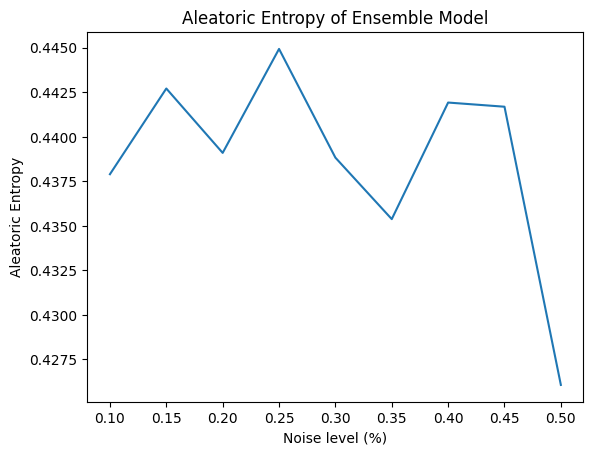

In [29]:
import matplotlib.pyplot as plt

# sketch graph for mean aleatoric entropy of ensemble model
plt.plot(noise_frac, np.mean(ale_entropy_ensemble, axis=1))
plt.xlabel('Noise level (%)')
plt.ylabel('Aleatoric Entropy')
plt.title('Aleatoric Entropy of Ensemble Model')
plt.show()

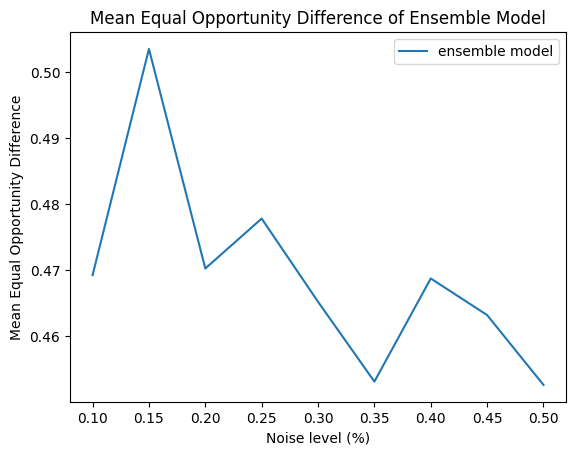

In [30]:
# sketch graph of mean equal opportunity difference for ensemble model
plt.plot(noise_frac, Equal_opp_diffs_ensemble, label='ensemble model')
plt.xlabel('Noise level (%)')
plt.ylabel('Mean Equal Opportunity Difference')
plt.title('Mean Equal Opportunity Difference of Ensemble Model')
plt.legend()
plt.show()


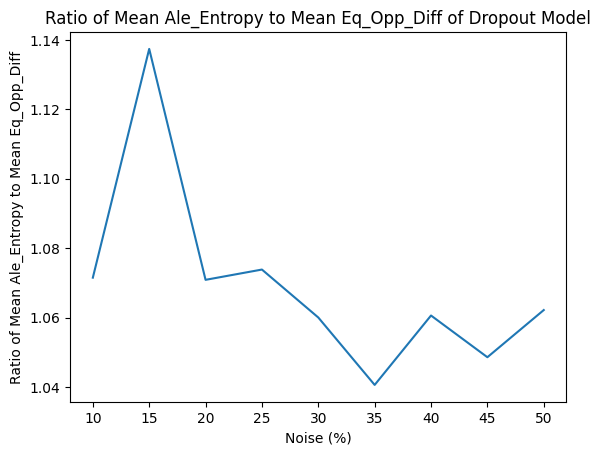

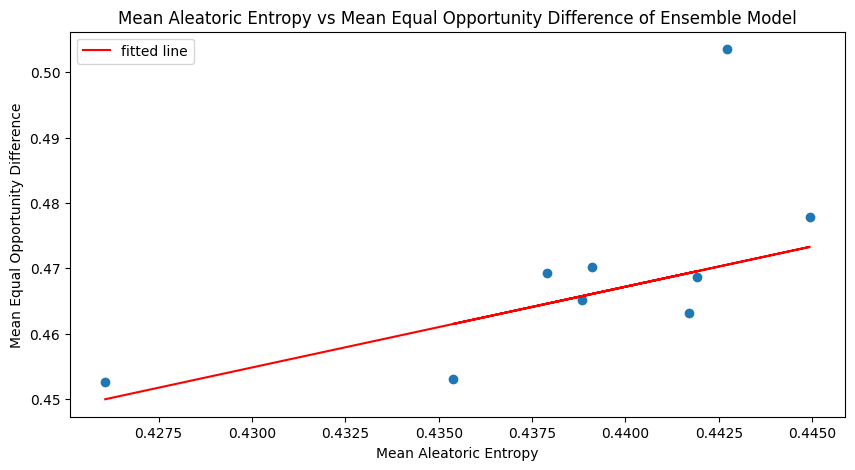

In [79]:
# calculate the ratio of mean equal opportunity difference to mean aleatoric entropy
ratio_dropout = Equal_opp_diffs_ensemble/np.mean(ale_entropy_ensemble, axis=1)
plt.plot(noise_frac*100, ratio_dropout, label='ensemble model')
plt.xlabel('Noise (%)') # noise level added
plt.ylabel('Ratio of Mean Ale_Entropy to Mean Eq_Opp_Diff')
plt.title('Ratio of Mean Ale_Entropy to Mean Eq_Opp_Diff of Dropout Model')
plt.show()

# draw a best fit line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(np.mean(ale_entropy_ensemble[0:1] + ale_entropy_ensemble[2:], axis=1), Equal_opp_diffs_ensemble[0:1] + Equal_opp_diffs_ensemble[2:])
plt.figure(figsize=(10, 5))
plt.scatter(np.mean(ale_entropy_ensemble, axis=1), Equal_opp_diffs_ensemble)
plt.plot(np.mean(ale_entropy_ensemble[0:1] + ale_entropy_ensemble[2:], axis=1), intercept + slope*np.mean(ale_entropy_ensemble[0:1] + ale_entropy_ensemble[2:], axis=1), 'r', label='fitted line')
plt.xlabel('Mean Aleatoric Entropy')
plt.ylabel('Mean Equal Opportunity Difference')
plt.title('Mean Aleatoric Entropy vs Mean Equal Opportunity Difference of Ensemble Model')
plt.legend()
plt.show()


In [34]:
#ale_entropy_ensemble to dict
ale_entropy_ensemble_dict = {}
for i in range(len(noise_frac)):
    ale_entropy_ensemble_dict[noise_frac[i]] = ale_entropy_ensemble[i]
    
#epi_entropy_ensemble to dict
epi_entropy_ensemble_dict = {}
for i in range(len(noise_frac)):
    epi_entropy_ensemble_dict[noise_frac[i]] = epi_entropy_ensemble[i]

#save to pickle file
import pickle

with open('adult_results_aleatoric/ale_entropy_ensemble_dict.pickle', 'wb') as handle:
    pickle.dump(ale_entropy_ensemble_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('adult_results_aleatoric/epi_entropy_ensemble_dict.pickle', 'wb') as handle:
    pickle.dump(epi_entropy_ensemble_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('adult_results_aleatoric/Equal_opp_diffs_ensemble.pickle', 'wb') as handle:
    pickle.dump(Equal_opp_diffs_ensemble, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

### DROP OUT MODEL

In [36]:
# train dropout model for noise levels size 0.1 to 1.0
ale_entropy_dropout = []
epi_entropy_dropout = []
pred_prob = []

for i in range(len(noise_frac)):
    print('Noise %: ', np.round(noise_frac[i]*100,1))
    pred, ale_entropy, epi_entropy = train_dropout_model(train_sets[0].drop(['Income Binary'], axis=1), train_sets[0]['Income Binary'], dataset_orig_test.features, prob=0.2)
    print('ale entropy: ', np.mean(ale_entropy))
    print('epi entropy: ', np.mean(epi_entropy))

    # save ale and epi entropy
    pred_prob.append(pred)
    ale_entropy_dropout.append(ale_entropy)
    epi_entropy_dropout.append(epi_entropy)

    print('')

Noise %:  10.0
Epoch 1/100
123/123 - 3s - loss: 0.5342 - accuracy: 0.7421 - val_loss: 0.7499 - val_accuracy: 0.6389 - 3s/epoch - 22ms/step
Epoch 2/100
123/123 - 1s - loss: 0.4423 - accuracy: 0.7973 - val_loss: 0.8699 - val_accuracy: 0.6393 - 1s/epoch - 10ms/step
Epoch 3/100
123/123 - 1s - loss: 0.4317 - accuracy: 0.7996 - val_loss: 0.9215 - val_accuracy: 0.6415 - 1s/epoch - 9ms/step
Epoch 4/100
123/123 - 1s - loss: 0.4293 - accuracy: 0.8010 - val_loss: 0.9578 - val_accuracy: 0.6430 - 1s/epoch - 9ms/step
Epoch 5/100
123/123 - 1s - loss: 0.4277 - accuracy: 0.8029 - val_loss: 0.9709 - val_accuracy: 0.6408 - 1s/epoch - 9ms/step
Epoch 6/100
123/123 - 1s - loss: 0.4273 - accuracy: 0.8024 - val_loss: 0.9783 - val_accuracy: 0.6429 - 1s/epoch - 9ms/step
Epoch 7/100
123/123 - 1s - loss: 0.4267 - accuracy: 0.8033 - val_loss: 0.9581 - val_accuracy: 0.6443 - 1s/epoch - 10ms/step
Epoch 8/100
123/123 - 1s - loss: 0.4260 - accuracy: 0.8016 - val_loss: 0.9836 - val_accuracy: 0.6402 - 1s/epoch - 10ms/st

In [37]:
Equal_opp_diffs_dropout = equal_opportunity_difference(dataset_orig_test, pred_prob, 0.5)

Equal opportunity difference for dataset of size 0.10 = 0.488490
Equal opportunity difference for dataset of size 0.20 = 0.474773
Equal opportunity difference for dataset of size 0.30 = 0.473764
Equal opportunity difference for dataset of size 0.40 = 0.504541
Equal opportunity difference for dataset of size 0.50 = 0.485873
Equal opportunity difference for dataset of size 0.60 = 0.512614
Equal opportunity difference for dataset of size 0.70 = 0.478809
Equal opportunity difference for dataset of size 0.80 = 0.480827
Equal opportunity difference for dataset of size 0.90 = 0.497572


In [38]:
#mean of each entropy in ale and epi_entropy_dropout
for i in range(len(noise_frac)):
    print('Noise: ', np.round(noise_frac[i]*100), '%')
    print('ale entropy: ', np.mean(ale_entropy_dropout[i]))
    print('epi entropy: ', np.mean(epi_entropy_dropout[i]))
    print('')
    

Noise:  10.0 %
ale entropy:  0.4290806083118236
epi entropy:  0.42216397924906357

Noise:  15.0 %
ale entropy:  0.4135982932767536
epi entropy:  0.3850693913097399

Noise:  20.0 %
ale entropy:  0.41094415452131716
epi entropy:  0.379318801239682

Noise:  25.0 %
ale entropy:  0.4111207383862086
epi entropy:  0.3798212079621956

Noise:  30.0 %
ale entropy:  0.4238558264082922
epi entropy:  0.42441939443966575

Noise:  35.0 %
ale entropy:  0.42996241727266066
epi entropy:  0.4300322556982331

Noise:  40.0 %
ale entropy:  0.4200086906090081
epi entropy:  0.42020149474545654

Noise:  45.0 %
ale entropy:  0.4126610967530264
epi entropy:  0.3781343590442477

Noise:  50.0 %
ale entropy:  0.42152754689934424
epi entropy:  0.3890113585709568



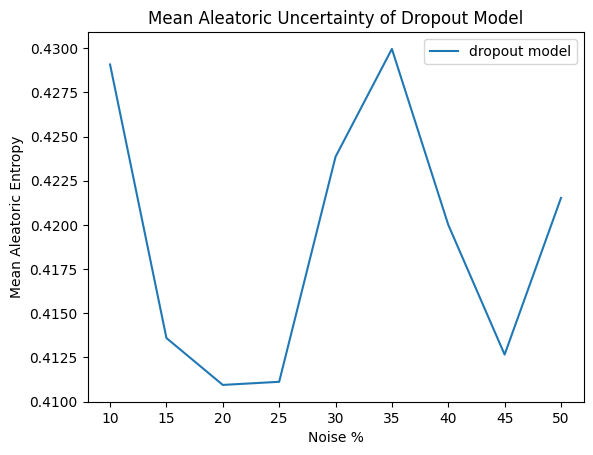

In [39]:
# sketch graph of aleatoric entropy for dropout model
plt.plot(noise_frac*100, np.mean(ale_entropy_dropout, axis=1), label='dropout model')
plt.xlabel('Noise %') # noise level
plt.ylabel('Mean Aleatoric Entropy')
plt.title('Mean Aleatoric Uncertainty of Dropout Model')
plt.legend()
plt.show()


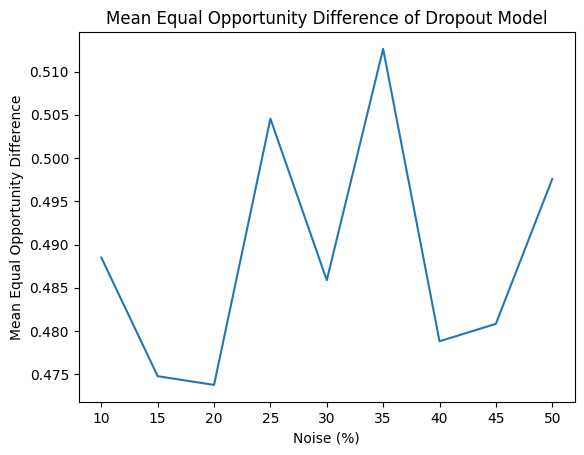

In [40]:
# sketch graph of mean equal opportunity difference for dropout model
plt.plot(noise_frac*100, Equal_opp_diffs_dropout, label='dropout model')
plt.xlabel('Noise (%)') # noise level added
plt.ylabel('Mean Equal Opportunity Difference')
plt.title('Mean Equal Opportunity Difference of Dropout Model')
plt.show()


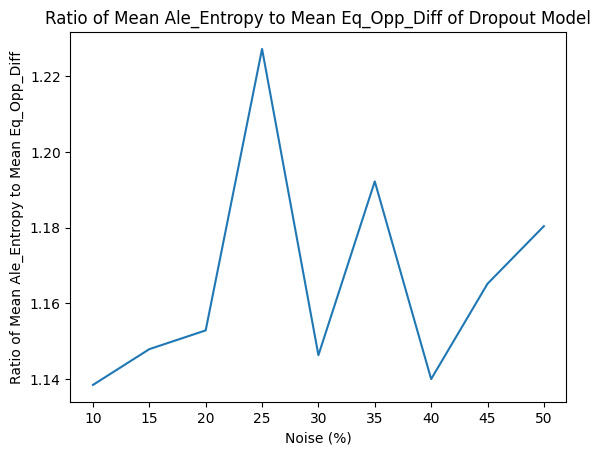

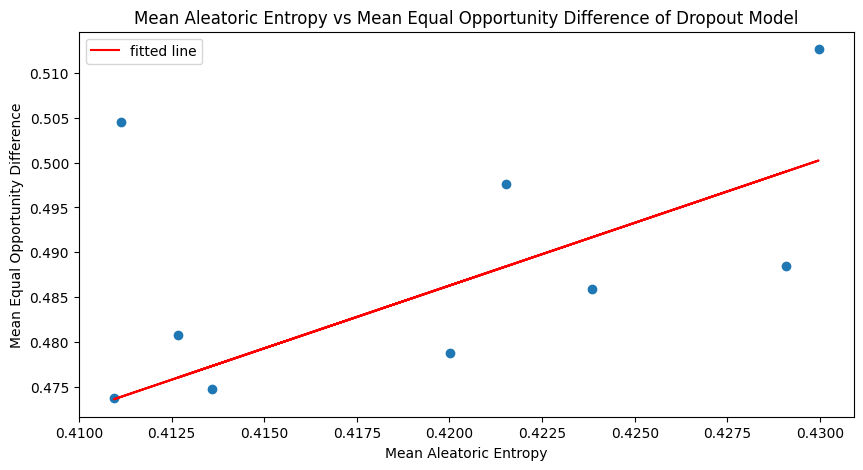

In [71]:
# calculate the ratio of mean aleatoric entropy to mean equal opportunity difference
ratio_dropout = Equal_opp_diffs_dropout/np.mean(ale_entropy_dropout, axis=1)
plt.plot(noise_frac*100, ratio_dropout, label='dropout model')
plt.xlabel('Noise (%)') # noise level added
plt.ylabel('Ratio of Mean Ale_Entropy to Mean Eq_Opp_Diff')
plt.title('Ratio of Mean Ale_Entropy to Mean Eq_Opp_Diff of Dropout Model')
plt.show()

# draw a best fit line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(np.mean(ale_entropy_dropout[0:3] + ale_entropy_dropout[4:], axis=1), Equal_opp_diffs_dropout[0:3] + Equal_opp_diffs_dropout[4:])
plt.figure(figsize=(10, 5))
plt.scatter(np.mean(ale_entropy_dropout, axis=1), Equal_opp_diffs_dropout)
# plt.plot(np.mean(ale_entropy_dropout, axis=1), intercept + slope*np.mean(ale_entropy_dropout, axis=1), 'r', label='fitted line')
plt.plot(np.mean(ale_entropy_dropout[0:3] + ale_entropy_dropout[4:], axis=1), intercept + slope*np.mean(ale_entropy_dropout[0:3] + ale_entropy_dropout[4:], axis=1), 'r', label='fitted line')
plt.xlabel('Mean Aleatoric Entropy')
plt.ylabel('Mean Equal Opportunity Difference')
plt.title('Mean Aleatoric Entropy vs Mean Equal Opportunity Difference of Dropout Model')
plt.legend()
plt.show()


In [ ]:
#ale_entropy_dropout to dict
ale_entropy_dropout_dict = {}
for i in range(0, 10):
    ale_entropy_dropout_dict[noise_frac[i]] = ale_entropy_dropout[i]

#epi_entropy_dropout to dict
epi_entropy_dropout_dict = {}
for i in range(0, 10):
    epi_entropy_dropout_dict[noise_frac[i]] = epi_entropy_dropout[i]
    
#save to pickle file
import pickle

with open('adult_results_aleatoric/ale_entropy_dropout_dict.pickle', 'wb') as handle:
    pickle.dump(ale_entropy_dropout_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('adult_results_aleatoric/epi_entropy_dropout_dict.pickle', 'wb') as handle:
    pickle.dump(epi_entropy_dropout_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('adult_results_aleatoric/Equal_opp_diffs_dropout.pickle', 'wb') as handle:
    pickle.dump(Equal_opp_diffs_dropout, handle, protocol=pickle.HIGHEST_PROTOCOL)



### ENSEMBLE DROP OUT MODEL

In [80]:
# train ensemble dropout model for dataset size 0.1 to 1.0
ale_entropy_ensemble_dropout = []
epi_entropy_ensemble_dropout = []
pred_prob_ensemble_dropout = []

for i in range(len(noise_frac)):
    print('Noise %: ', np.round(noise_frac[i]*100,1))
    pred, ale_entropy, epi_entropy = train_dropout_ensemble_model(train_sets[i].drop(['Income Binary'], axis=1), train_sets[i]['Income Binary'], dataset_orig_test.features, prob=0.2)
    print('ale entropy: ', np.mean(ale_entropy))
    print('epi entropy: ', np.mean(epi_entropy))

    # save ale and epi entropy
    ale_entropy_ensemble_dropout.append(ale_entropy)
    epi_entropy_ensemble_dropout.append(epi_entropy)
    pred_prob_ensemble_dropout.append(pred)

    print('')

Noise (%) 10.0
Epoch 1/100
123/123 - 40s - loss: 0.5161 - accuracy: 0.7571 - val_loss: 0.7884 - val_accuracy: 0.6371 - 40s/epoch - 328ms/step
Epoch 2/100
123/123 - 3s - loss: 0.4381 - accuracy: 0.7973 - val_loss: 0.8792 - val_accuracy: 0.6448 - 3s/epoch - 22ms/step
Epoch 3/100
123/123 - 2s - loss: 0.4312 - accuracy: 0.8016 - val_loss: 0.9273 - val_accuracy: 0.6440 - 2s/epoch - 16ms/step
Epoch 4/100
123/123 - 2s - loss: 0.4279 - accuracy: 0.8021 - val_loss: 0.9479 - val_accuracy: 0.6434 - 2s/epoch - 20ms/step
Epoch 5/100
123/123 - 2s - loss: 0.4269 - accuracy: 0.8027 - val_loss: 0.9699 - val_accuracy: 0.6417 - 2s/epoch - 14ms/step
Epoch 6/100
123/123 - 2s - loss: 0.4261 - accuracy: 0.8029 - val_loss: 1.0043 - val_accuracy: 0.6444 - 2s/epoch - 15ms/step
Epoch 7/100
123/123 - 2s - loss: 0.4263 - accuracy: 0.8037 - val_loss: 0.9951 - val_accuracy: 0.6438 - 2s/epoch - 13ms/step
Epoch 8/100
123/123 - 1s - loss: 0.4260 - accuracy: 0.8045 - val_loss: 0.9879 - val_accuracy: 0.6441 - 1s/epoch - 

KeyError: 9

In [84]:
Equal_opp_diffs_ensemble_dropout = equal_opportunity_difference(dataset_orig_test, pred_prob_ensemble_dropout, 0.5)

Equal opportunity difference for dataset of size 0.10 = 0.484864
Equal opportunity difference for dataset of size 0.20 = 0.497982
Equal opportunity difference for dataset of size 0.30 = 0.480827
Equal opportunity difference for dataset of size 0.40 = 0.459637
Equal opportunity difference for dataset of size 0.50 = 0.468718
Equal opportunity difference for dataset of size 0.60 = 0.460141
Equal opportunity difference for dataset of size 0.70 = 0.459637
Equal opportunity difference for dataset of size 0.80 = 0.454591
Equal opportunity difference for dataset of size 0.90 = 0.463768


In [86]:
#mean of each entropy in ale and epi_entropy_ensemble_dropout
for i in range(len(noise_frac)):
    print('Noise %: ', np.round(noise_frac[i]*100,1))
    print('ale entropy: ', np.mean(ale_entropy_ensemble_dropout[i]))
    print('epi entropy: ', np.mean(epi_entropy_ensemble_dropout[i]))
    print('')

Noise %:  10.0
ale entropy:  0.42706808263107754
epi entropy:  0.4210028122943627

Noise %:  15.0
ale entropy:  0.43015349403392084
epi entropy:  0.4230549458328678

Noise %:  20.0
ale entropy:  0.42848663123287506
epi entropy:  0.4160506341751966

Noise %:  25.0
ale entropy:  0.4640353012433047
epi entropy:  0.44272474892548147

Noise %:  30.0
ale entropy:  0.48140676983318537
epi entropy:  0.4480446367764664

Noise %:  35.0
ale entropy:  0.5027786400367442
epi entropy:  0.48386298961655916

Noise %:  40.0
ale entropy:  0.5208171108016688
epi entropy:  0.49832614351185334

Noise %:  45.0
ale entropy:  0.5447117099468785
epi entropy:  0.5263333246889781

Noise %:  50.0
ale entropy:  0.5522169317841653
epi entropy:  0.5274257135674331



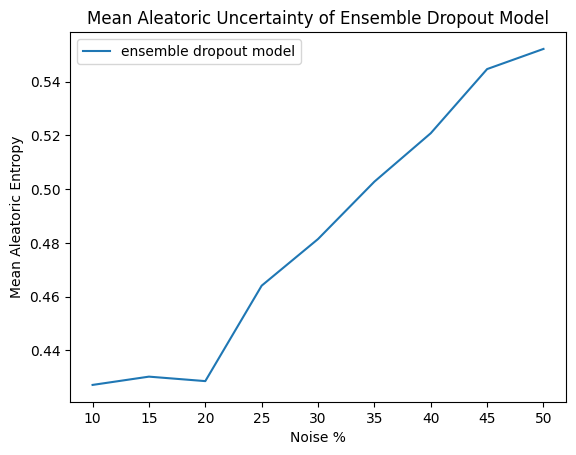

In [87]:
# sketch graph for mean epistemic entropy of ensemble dropout model
plt.plot(noise_frac*100, np.mean(ale_entropy_ensemble_dropout, axis=1), label='ensemble dropout model')
plt.xlabel('Noise %') # noise level
plt.ylabel('Mean Aleatoric Entropy')
plt.title('Mean Aleatoric Uncertainty of Ensemble Dropout Model')
plt.legend()
plt.show()


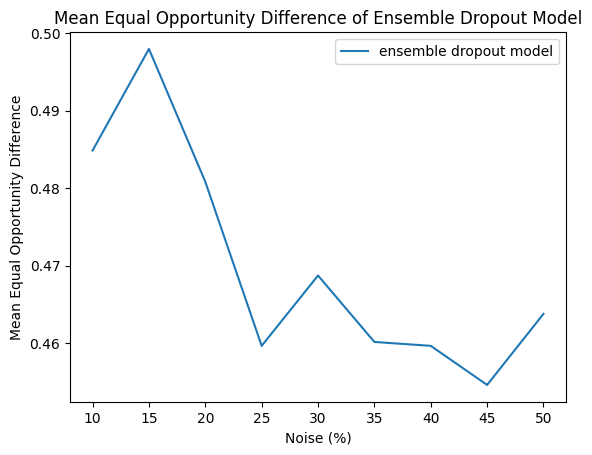

In [88]:
# sketch graph of mean equal opportunity difference for ensemble dropout model
plt.plot(noise_frac*100, Equal_opp_diffs_ensemble_dropout, label='ensemble dropout model')
plt.xlabel('Noise (%)') # noise level added
plt.ylabel('Mean Equal Opportunity Difference')
plt.title('Mean Equal Opportunity Difference of Ensemble Dropout Model')
plt.legend()
plt.show()

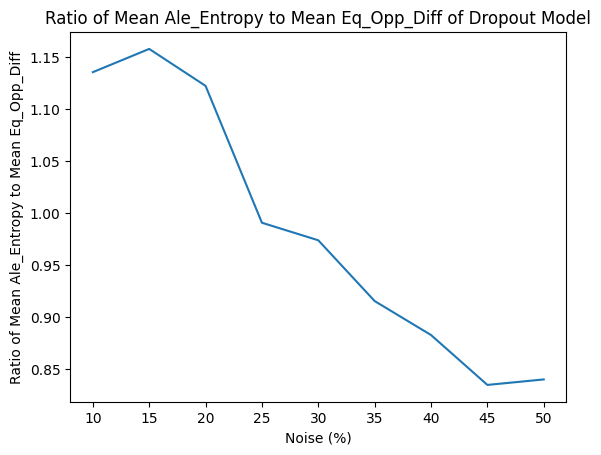

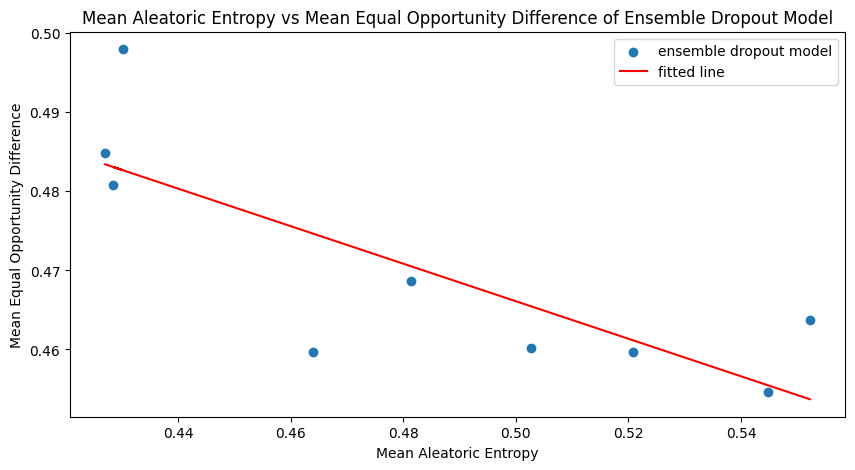

In [94]:
# calculate the ratio of mean aleatoric entropy to mean equal opportunity difference
ratio_dropout = Equal_opp_diffs_ensemble_dropout/np.mean(ale_entropy_ensemble_dropout, axis=1)
plt.plot(noise_frac*100, ratio_dropout, label='dropout model')
plt.xlabel('Noise (%)') # noise level added
plt.ylabel('Ratio of Mean Ale_Entropy to Mean Eq_Opp_Diff')
plt.title('Ratio of Mean Ale_Entropy to Mean Eq_Opp_Diff of Dropout Model')
plt.show()

# draw a best fit line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(np.mean(ale_entropy_ensemble_dropout, axis=1), Equal_opp_diffs_ensemble_dropout)
plt.figure(figsize=(10, 5))
plt.scatter(np.mean(ale_entropy_ensemble_dropout, axis=1), Equal_opp_diffs_ensemble_dropout, label='ensemble dropout model')
plt.plot(np.mean(ale_entropy_ensemble_dropout, axis=1), intercept + slope*np.mean(ale_entropy_ensemble_dropout, axis=1), 'r', label='fitted line')
plt.xlabel('Mean Aleatoric Entropy')
plt.ylabel('Mean Equal Opportunity Difference')
plt.title('Mean Aleatoric Entropy vs Mean Equal Opportunity Difference of Ensemble Dropout Model')
plt.legend()
plt.show()


In [27]:
#save to pickle file
import pickle

with open('adult_results/ale_entropy_ensemble_dropout_dict.pickle', 'wb') as handle:
    pickle.dump(ale_entropy_ensemble_dropout, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('adult_results/epi_entropy_ensemble_dropout_dict.pickle', 'wb') as handle:
    pickle.dump(epi_entropy_ensemble_dropout, handle, protocol=pickle.HIGHEST_PROTOCOL)

# #load pickle file
# import pickle

# with open('adult_results/ale_entropy_ensemble_dropout_dict.pickle', 'rb') as handle:
#     ale_entropy_ensemble_dropout = pickle.load(handle)

# with open('adult_results/epi_entropy_ensemble_dropout_dict.pickle', 'rb') as handle:
#     epi_entropy_ensemble_dropout = pickle.load(handle)
